In [24]:
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre

# Step 1: Load the recording
local_path = '/media/shruti/T9/Caren/MEASlices_02242025_PVSandCA/MEASlices_02242025_PVSandCA/250224/M07305/Network/000002/data.raw.h5'
recording = se.read_maxwell(local_path, stream_id='well002')

# Step 2: Bandpass filter the recording
freq_min = 300
freq_max = 4500
recording_bp = spre.bandpass_filter(recording, freq_min=freq_min, freq_max=freq_max)

# Step 3: Apply common median reference
recording_cmr = spre.common_reference(recording_bp, reference='global', operator='median')

# Step 4: Slice the recording (e.g., first 300 seconds)
fs = recording.get_sampling_frequency()
recording_chunk = recording_cmr.frame_slice(start_frame=0, end_frame=int(300 * fs))

print(f"Chunk duration: {recording_chunk.get_total_duration()} seconds")

Chunk duration: 300.0 seconds


In [27]:
# Step 5: Select specific channels
# For example, to select channels with IDs 10, 25, and 37 (you can adjust this list)
selected_channel_ids = [927, 934, 935, 938, 939, 942, 943, 947, 950, 951, 955, 959, 963, 
                    966, 967, 971, 974, 975, 979, 983, 987, 991, 995, 
                    998, 999, 1003, 1007, 1011, 1015]  # replace with your desired channel IDs

# Convert selected_channel_ids to strings to match the channel_ids in recording_chunk
selected_channel_ids_str = [str(ch) for ch in selected_channel_ids]

# Slice the recording to keep only the selected channels
recording_chunk = recording_chunk.channel_slice(channel_ids=selected_channel_ids_str)

# Confirm selection
print(f"Selected channels: {recording_chunk.get_channel_ids()}")
print(f"New shape (channels x frames): {recording_chunk.get_num_channels()} x {recording_chunk.get_num_frames()}")


Selected channels: ['927' '934' '935' '938' '939' '942' '943' '947' '950' '951' '955' '959'
 '963' '966' '967' '971' '974' '975' '979' '983' '987' '991' '995' '998'
 '999' '1003' '1007' '1011' '1015']
New shape (channels x frames): 29 x 3000000


In [28]:
# Step 1: Get channel IDs and locations
channel_ids = recording_chunk.get_channel_ids()
locations = recording_chunk.get_channel_locations()

# Step 2: Map electrodes based on locations
electrodes = []
channel_location_dict = {}
for channel, loc in zip(channel_ids, locations):
    electrode_id = 220 * int(loc[1] / 17.5) + int(loc[0] / 17.5)
    electrodes.append(electrode_id)
    channel_location_dict[channel] = electrode_id

print(f"Mapped {len(electrodes)} electrodes.")

Mapped 29 electrodes.


In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Define the channels to analyze
#channels_to_plot = [927, 934, 935, 938, 939, 942, 943, 947, 950, 951, 955, 959, 963, 
                    #966, 967, 971, 974, 975, 979, 983, 987, 991, 995, 
                    #998, 999, 1003, 1007, 1011, 1015]  # Replace with desired channel indices


fs = recording_chunk.get_sampling_frequency()

# Step 2: Extract traces for a specific time range
start_time = 40  # Start time in seconds
end_time = 60    # End time in seconds
traces = recording_chunk.get_traces(
    start_frame=int(start_time * fs),
    end_frame=int(end_time * fs),
    segment_index=0,
    return_scaled=True
)

# Step 3: Detect spikes using a standard deviation threshold
def detect_peaks_stddev(trace, peak_sign, std_multiplier):
    mean = np.mean(trace)
    std = np.std(trace)
    threshold = mean + std_multiplier * std if peak_sign == "pos" else mean - std_multiplier * std
    if peak_sign == "pos":
        peaks = np.where((trace[1:-1] > trace[:-2]) & (trace[1:-1] > trace[2:]) & (trace[1:-1] > threshold))[0] + 1
    elif peak_sign == "neg":
        peaks = np.where((trace[1:-1] < trace[:-2]) & (trace[1:-1] < trace[2:]) & (trace[1:-1] < threshold))[0] + 1
    else:
        raise ValueError("peak_sign must be 'pos' or 'neg'")
    return peaks, threshold

# Step 4: Analyze each channel
peak_sign = "neg"
std_multiplier = 4

# Filter channels_to_plot to include only valid indices
valid_channels_to_plot = [ch for ch in selected_channel_ids if ch < traces.shape[1]]

for channel_idx in selected_channel_ids:
    trace = traces[:, selected_channel_ids.index(channel_idx)]
    peaks, threshold = detect_peaks_stddev(trace, peak_sign, std_multiplier)
    print(f"Channel {selected_channel_ids.index(channel_idx)}: Detected {len(peaks)} spikes")

Channel 0: Detected 39 spikes
Channel 1: Detected 22 spikes
Channel 2: Detected 27 spikes
Channel 3: Detected 17 spikes
Channel 4: Detected 50 spikes
Channel 5: Detected 53 spikes
Channel 6: Detected 6 spikes
Channel 7: Detected 14 spikes
Channel 8: Detected 25 spikes
Channel 9: Detected 33 spikes
Channel 10: Detected 34 spikes
Channel 11: Detected 18 spikes
Channel 12: Detected 41 spikes
Channel 13: Detected 13 spikes
Channel 14: Detected 22 spikes
Channel 15: Detected 33 spikes
Channel 16: Detected 35 spikes
Channel 17: Detected 20 spikes
Channel 18: Detected 30 spikes
Channel 19: Detected 27 spikes
Channel 20: Detected 8 spikes
Channel 21: Detected 18 spikes
Channel 22: Detected 18 spikes
Channel 23: Detected 23 spikes
Channel 24: Detected 7 spikes
Channel 25: Detected 36 spikes
Channel 26: Detected 13 spikes
Channel 27: Detected 16 spikes
Channel 28: Detected 8 spikes


/home/shruti/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


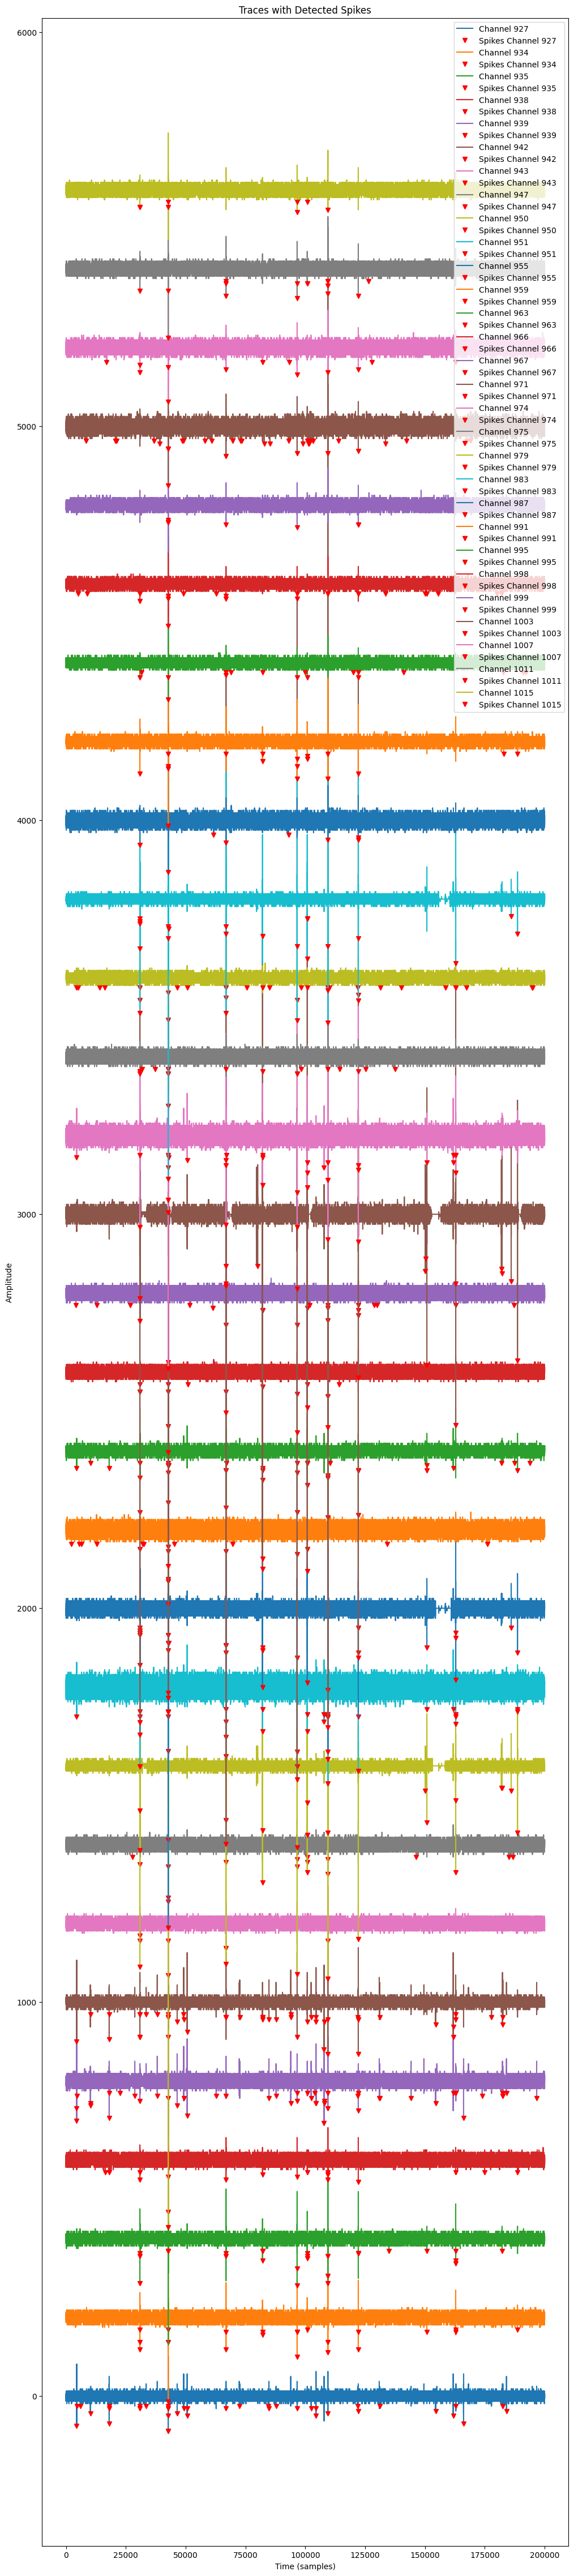

In [34]:
# Step 1: Filter channels_to_plot to include only valid channel indices
valid_channels_to_plot = [ch for ch in selected_channel_ids if ch < traces.shape[1]]
channel_idx = selected_channel_ids.index(channel_idx)
# Step 1: Plot traces with detected spikes
plt.figure(figsize=(12, len(selected_channel_ids) * 2))
for i, channel_idx in enumerate(selected_channel_ids):
    trace = traces[:, selected_channel_ids.index(channel_idx)]
    peaks, _ = detect_peaks_stddev(trace, peak_sign, std_multiplier)
    plt.plot(trace + i * 200, label=f"Channel {channel_idx}")
    plt.plot(peaks, trace[peaks] + i * 200, 'rv', label=f"Spikes Channel {channel_idx}")

plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.title("Traces with Detected Spikes")
plt.legend()
plt.show()

In [41]:
# Step 1: Calculate firing rates for each channel
total_duration = recording_chunk.get_total_duration()
firing_rates = {}
for channel_idx in selected_channel_ids:
    # Map channel ID to its corresponding index in the traces array
    channel_index = selected_channel_ids.index(channel_idx)
    trace = traces[:, channel_index]
    peaks, _ = detect_peaks_stddev(trace, peak_sign, std_multiplier)
    firing_rate = len(peaks) / total_duration
    firing_rates[channel_idx] = firing_rate

# Step 2: Display firing rates
for channel_idx, rate in firing_rates.items():
    print(f"Channel {channel_idx}: Firing Rate = {rate:.2f} Hz")

Channel 927: Firing Rate = 0.13 Hz
Channel 934: Firing Rate = 0.07 Hz
Channel 935: Firing Rate = 0.09 Hz
Channel 938: Firing Rate = 0.06 Hz
Channel 939: Firing Rate = 0.17 Hz
Channel 942: Firing Rate = 0.18 Hz
Channel 943: Firing Rate = 0.02 Hz
Channel 947: Firing Rate = 0.05 Hz
Channel 950: Firing Rate = 0.08 Hz
Channel 951: Firing Rate = 0.11 Hz
Channel 955: Firing Rate = 0.11 Hz
Channel 959: Firing Rate = 0.06 Hz
Channel 963: Firing Rate = 0.14 Hz
Channel 966: Firing Rate = 0.04 Hz
Channel 967: Firing Rate = 0.07 Hz
Channel 971: Firing Rate = 0.11 Hz
Channel 974: Firing Rate = 0.12 Hz
Channel 975: Firing Rate = 0.07 Hz
Channel 979: Firing Rate = 0.10 Hz
Channel 983: Firing Rate = 0.09 Hz
Channel 987: Firing Rate = 0.03 Hz
Channel 991: Firing Rate = 0.06 Hz
Channel 995: Firing Rate = 0.06 Hz
Channel 998: Firing Rate = 0.08 Hz
Channel 999: Firing Rate = 0.02 Hz
Channel 1003: Firing Rate = 0.12 Hz
Channel 1007: Firing Rate = 0.04 Hz
Channel 1011: Firing Rate = 0.05 Hz
Channel 1015: Fir

In [44]:
import spikeinterface.sorters as ss
import spikeinterface.widgets as sw

# Step 1: Select the specific channel (e.g., 972)
channel_id_to_sort = 927
recording_single_channel = recording_chunk.channel_slice(channel_ids=[str(channel_id_to_sort)])

# Step 2: Run spike sorting (e.g., using SpykingCircus)
sorting_output_folder = "spykingcircus_output"
sorting = ss.run_sorter('spykingcircus', recording_single_channel, output_folder=sorting_output_folder)

# Step 3: Plot the traces and detected spikes
# Extract traces for visualization
traces_single_channel = recording_single_channel.get_traces(return_scaled=True)

# Plot the traces
sw.plot_timeseries(recording_single_channel)

# Plot the spike trains
sw.plot_rasters(sorting)

/tmp/ipykernel_18112/1145391062.py:10: DeprecationWarning: `output_folder` is deprecated and will be removed in version 0.103.0 Please use folder instead
  sorting = ss.run_sorter('spykingcircus', recording_single_channel, output_folder=sorting_output_folder)


Exception: The sorter spykingcircus is not installed. Please install it with:

To use Spyking-Circus run:

        >>> pip install spyking-circus

        Need MPICH working, for ubuntu do:
            sudo apt install libmpich-dev mpich

        More information on Spyking-Circus at:
            https://spyking-circus.readthedocs.io/en/latest/
    